## Import

In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [234]:
data = pd.read_csv('diabetes.csv')

## Data Info

In [235]:
data.shape

(768, 9)

In [236]:
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [237]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [238]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


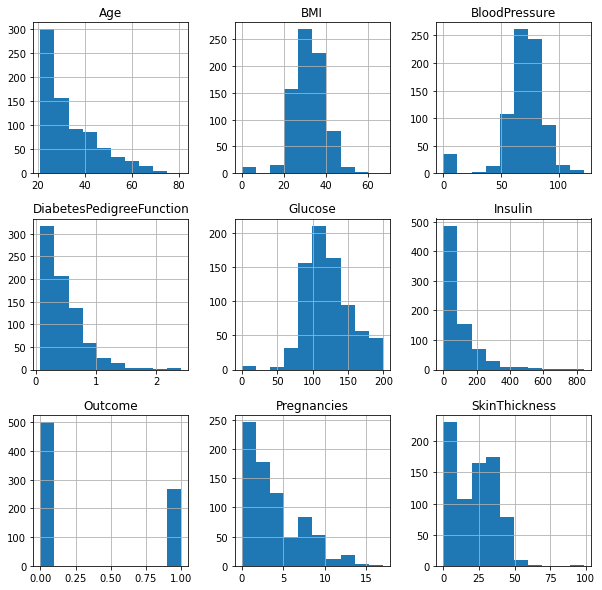

In [239]:
data.hist(figsize=(10,10));

## Split

In [240]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=0)

## EDA

##### Correlation

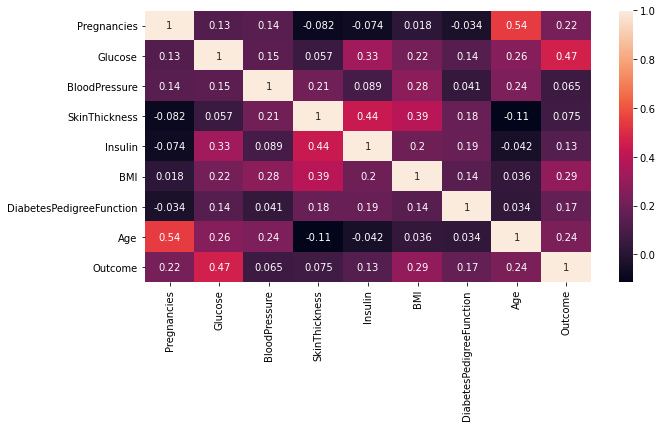

In [241]:
corr = data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True);

##### All variables categorical relation with Outcome

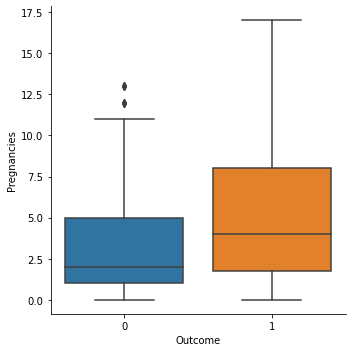

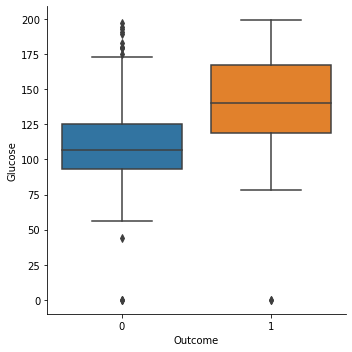

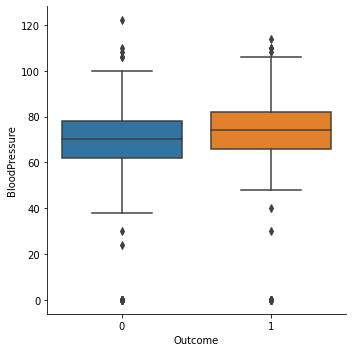

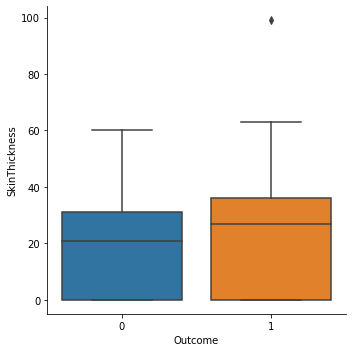

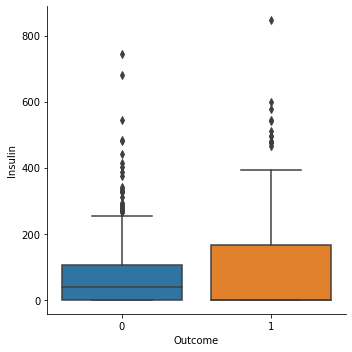

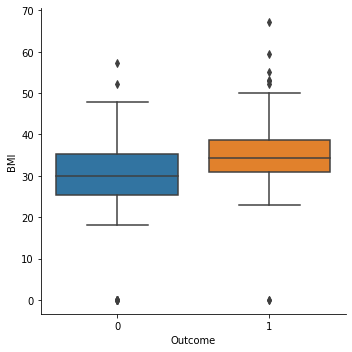

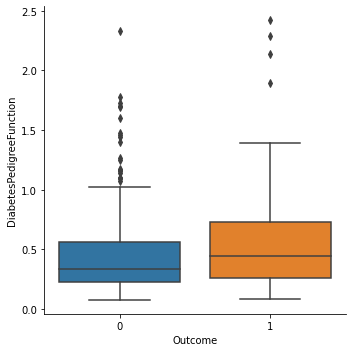

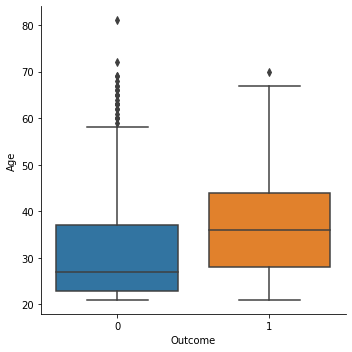

In [242]:
feats = data.columns[:8]
for i in feats:
    sns.catplot(data=data, x='Outcome', y=i, kind='box')

Pregnances, Glucose and Isulin apparently have the highest degree of what causes a person to obtain diabetes

##### BMI and Glucose

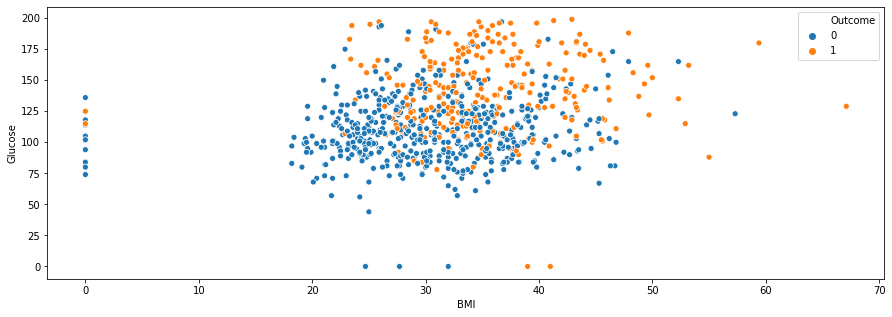

In [243]:
plt.figure(figsize=(15,5))
sns.scatterplot(data=data, x='BMI', y='Glucose', hue='Outcome');

## Outliers

In [244]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]

## Feats and Target

In [245]:
x_train = train.drop('Outcome', axis=1)
y_train = train['Outcome']

x_test = test.drop('Outcome', axis=1)
y_test = test['Outcome']

## Scale

In [246]:
from sklearn.preprocessing import RobustScaler
rb = RobustScaler()
x_train = rb.fit_transform(x_train)
x_test = rb.fit_transform(x_test)

## Model

In [247]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import RandomizedSearchCV

In [248]:
#XGBoost
xgb = XGBClassifier(n_estimators = 20, n_jobs=-1, min_child_weight= 1,
                     max_depth= 4,
                     learning_rate = 0.05,
                     gamma= 0.2,
                     colsample_bytree= 0.5).fit(x_train, y_train)

In [249]:
#SVC
svm = SVC(C=1, kernel='rbf').fit(x_train, y_train)

In [250]:
#ExtraTrees
extrees = ExtraTreesClassifier(n_jobs=-1, n_estimators=50).fit(x_train, y_train)

In [251]:
forest = RandomForestClassifier(n_jobs=-1, n_estimators=50).fit(x_train, y_train)

## Voting

In [262]:
voting = VotingClassifier(estimators=[
                        ('xgboost', xgb), ('svm', svm), ('extress', extrees), ('forest', forest)], voting='hard').fit(x_train, y_train)

## Stacking

In [267]:
estimators = [
('xgboost', xgb), ('svm', svm), ('extrees', extrees), ('forest', forest)]

stacking = StackingClassifier(estimators=estimators).fit(x_train, y_train)

0.8051948051948052

## Metrics

In [272]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score

##### Voting

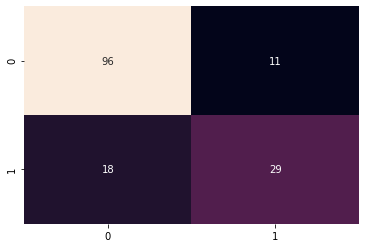

In [271]:
sns.heatmap(confusion_matrix(y_test, voting.predict(x_test)), annot=True, cbar=False, fmt='g');

In [275]:
print(accuracy_score(y_test, voting.predict(x_test)))
print(recall_score(y_test, voting.predict(x_test)))
print(precision_score(y_test, voting.predict(x_test)))

0.8116883116883117
0.6170212765957447
0.725


#### Stacking

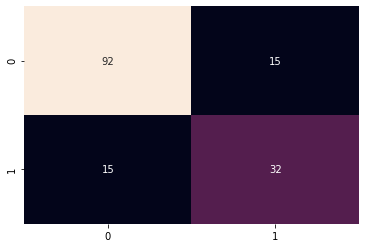

In [276]:
sns.heatmap(confusion_matrix(y_test, stacking.predict(x_test)), annot=True, cbar=False, fmt='g');

In [277]:
print(accuracy_score(y_test, stacking.predict(x_test)))
print(recall_score(y_test, stacking.predict(x_test)))
print(precision_score(y_test, stacking.predict(x_test)))

0.8051948051948052
0.6808510638297872
0.6808510638297872


## Save

In [ ]:
import pickle
pickle.dump(xgb,open("titanic_xgb.sav", "wb"))
pickle.dump(std, open("scaler.sav", "wb"))